In [19]:
import cv2
import numpy as np
import requests
from PIL import Image, ImageDraw
from matplotlib import cm

def show_webcam_feed():
    stream_url = 'http://10.80.105.234:5000/video_feed'  # Connected to webcam socket running locally from windows python script
    stream = requests.get(stream_url, stream=True)

    bytes_buffer = bytes()
    x = 50
    for chunk in stream.iter_content(chunk_size=1024):
        bytes_buffer += chunk
        a = bytes_buffer.find(b'\xff\xd8')  # JPEG start
        b = bytes_buffer.find(b'\xff\xd9')  # JPEG end
        if a != -1 and b != -1:
            jpg = bytes_buffer[a:b+2]  # Extract the JPEG image

            # draw = ImageDraw.Draw(jpg) # draw box on image

            bytes_buffer = bytes_buffer[b+2:]  # Remove the processed frame from buffer

            img = cv2.imdecode(np.frombuffer(jpg, dtype=np.uint8), cv2.IMREAD_COLOR)  # Convert JPEG to image
            cv2.rectangle(img, (x, x), (x+50, x+50), (0, 0, 255), 1)
            if img is not None:
                cv2.imshow('Webcam', img)
                if cv2.waitKey(1) == ord('q'):  # Exit on pressing 'q'
                    break

    cv2.destroyAllWindows()

if __name__ == '__main__':
    show_webcam_feed()


/home/robert/.pyenv/versions/3.10.6/envs/carbon_calculator/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-03-08 14:07:38.734391: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-08 14:07:38.775350: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-08 14:07:38.775377: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been reg

<class 'PIL.JpegImagePlugin.JpegImageFile'>


The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


Detected apple with confidence 0.97 at location [390.38, 485.78, 749.6, 807.38]
Detected orange with confidence 0.993 at location [122.93, 222.02, 587.37, 693.06]
Detected apple with confidence 0.993 at location [588.68, 399.17, 905.2, 686.63]


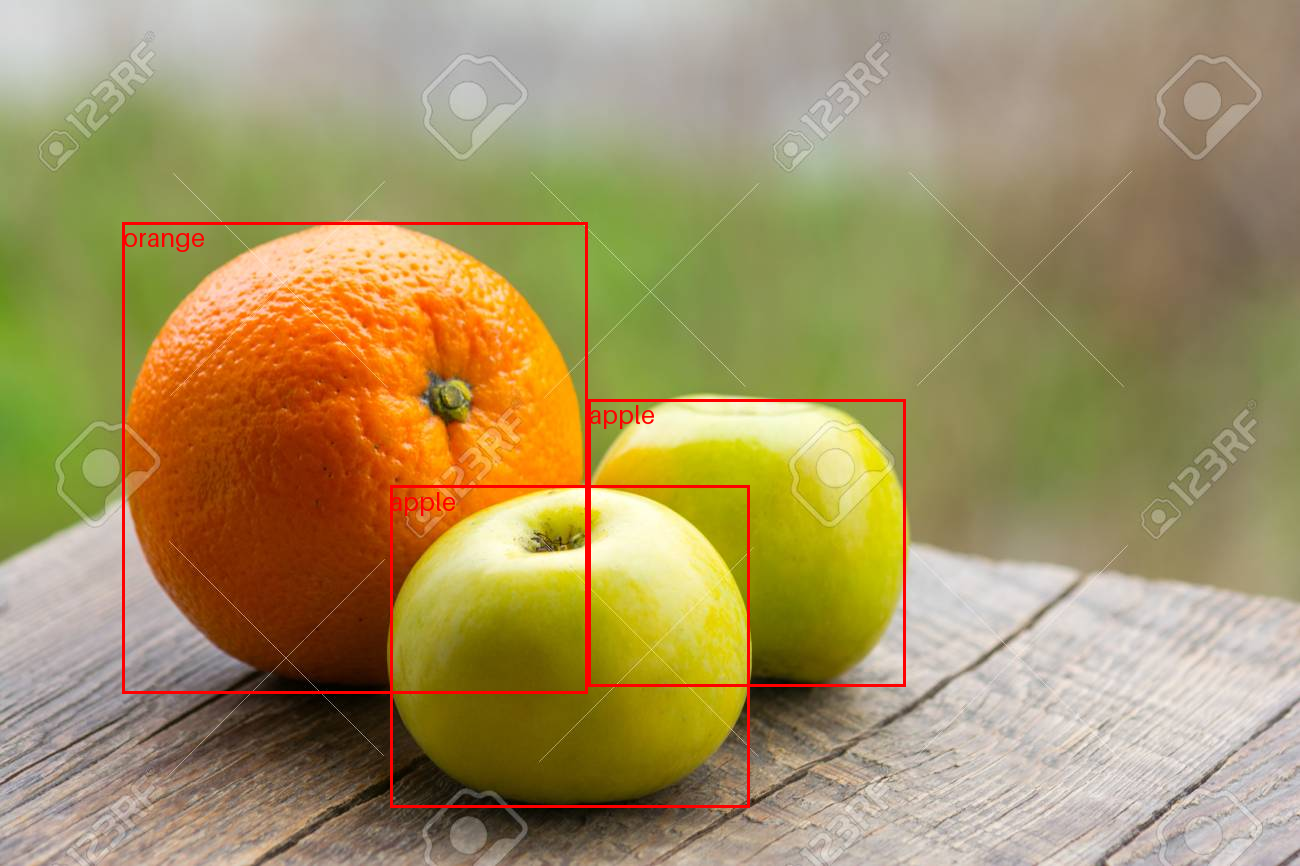

In [1]:
from transformers import YolosImageProcessor, YolosForObjectDetection
from PIL import Image, ImageDraw
import torch
import requests
from IPython.display import display

# url = "http://images.cocodataset.org/val2017/000000039769.jpg"
url = "https://previews.123rf.com/images/bazru/bazru1712/bazru171200002/91128431-juicy-ripe-fruits-on-a-table-in-garden.jpg"
image = Image.open(requests.get(url, stream=True).raw)

draw = ImageDraw.Draw(image)

model = YolosForObjectDetection.from_pretrained('hustvl/yolos-tiny')
image_processor = YolosImageProcessor.from_pretrained("hustvl/yolos-tiny")

inputs = image_processor(images=image, return_tensors="pt")
outputs = model(**inputs)

# model predicts bounding boxes and corresponding COCO classes
logits = outputs.logits
bboxes = outputs.pred_boxes

desired_classes = ['apple', 'banana', 'orange']

# print results
print(type(image))
target_sizes = torch.tensor([image.size[::-1]])
results = image_processor.post_process_object_detection(outputs, threshold=0.9, target_sizes=target_sizes)[0]
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    detected_class = model.config.id2label[label.item()]

    if detected_class in desired_classes:
        box = [round(i, 2) for i in box.tolist()]
        # draw rectangle on image
        draw.rectangle(box, outline='red', width=3)
        # draw object label
        draw.text(xy=box[:2], text=model.config.id2label[label.item()], font_size=25, fill='red')

        print(
            f"Detected {model.config.id2label[label.item()]} with confidence "
            f"{round(score.item(), 3)} at location {box}"
        )

display(image)

In [20]:
results

{'scores': tensor([0.9910, 0.9085, 0.9336, 0.9794, 0.9740], grad_fn=<IndexBackward0>),
 'labels': tensor([75, 75, 17, 17, 75]),
 'boxes': tensor([[ 46.4761,  72.7763, 178.9760, 119.3047],
         [336.4787,  79.2662, 368.2280, 192.3569],
         [337.1848,  18.0632, 638.1446, 373.0924],
         [ 10.9292,  53.7410, 313.4107, 470.6720],
         [ 41.6319,  72.2281, 178.0870, 119.9883]], grad_fn=<IndexBackward0>)}

In [12]:
# function to take an image and return bounding box and label
model = YolosForObjectDetection.from_pretrained('hustvl/yolos-tiny')
image_processor = YolosImageProcessor.from_pretrained("hustvl/yolos-tiny")

def obj_detection(image):
    draw = ImageDraw.Draw(image)

    inputs = image_processor(images=image, return_tensors="pt")
    outputs = model(**inputs)

    # model predicts bounding boxes and corresponding COCO classes
    logits = outputs.logits
    bboxes = outputs.pred_boxes

    desired_classes = ['apple', 'banana', 'orange']

    # print results
    target_sizes = torch.tensor([image.size[::-1]])
    results = image_processor.post_process_object_detection(outputs, threshold=0.9, target_sizes=target_sizes)[0]
    labels = []
    boxes = []
    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        detected_class = model.config.id2label[label.item()]

        if detected_class in desired_classes:
            box = [round(i, 2) for i in box.tolist()]
            # draw rectangle on image
            draw.rectangle(box, outline='red', width=3)
            # draw object label
            draw.text(xy=box[:2], text=model.config.id2label[label.item()], font_size=25, fill='red')
            labels.append(model.config.id2label[label.item()])
            boxes.append(box)

    return labels, boxes

In [14]:
# test obj_detection function
url = "https://previews.123rf.com/images/bazru/bazru1712/bazru171200002/91128431-juicy-ripe-fruits-on-a-table-in-garden.jpg"
image = Image.open(requests.get(url, stream=True).raw)
print(type(image))

labels, boxes = obj_detection(image)
labels, boxes

<class 'PIL.JpegImagePlugin.JpegImageFile'>


(['apple', 'orange', 'apple'],
 [[390.38, 485.78, 749.6, 807.38],
  [122.93, 222.02, 587.37, 693.06],
  [588.68, 399.17, 905.2, 686.63]])

In [17]:
def show_webcam_feed():
    stream_url = 'http://10.80.105.234:5000/video_feed'  # Connected to webcam socket running locally from windows python script
    stream = requests.get(stream_url, stream=True)

    bytes_buffer = bytes()
    x = 50
    for chunk in stream.iter_content(chunk_size=1024):
        bytes_buffer += chunk
        a = bytes_buffer.find(b'\xff\xd8')  # JPEG start
        b = bytes_buffer.find(b'\xff\xd9')  # JPEG end
        if a != -1 and b != -1:
            jpg = bytes_buffer[a:b+2]  # Extract the JPEG image
            jpg_pil = Image.open(io.BytesIO(jpg))
            print(type(jpg_pil))


            bytes_buffer = bytes_buffer[b+2:]  # Remove the processed frame from buffer

            img = cv2.imdecode(np.frombuffer(jpg, dtype=np.uint8), cv2.IMREAD_COLOR)  # Convert JPEG to image
            cv2.rectangle(img, (x, x), (x+50, x+50), (0, 0, 255), 1)
            if img is not None:
                cv2.imshow('Webcam', img)
                if cv2.waitKey(1) == ord('q'):  # Exit on pressing 'q'
                    break

    cv2.destroyAllWindows()

if __name__ == '__main__':
    show_webcam_feed()

<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'PIL.JpegImagePlugin.Jpeg

In [43]:
model.config.id2label.values()

dict_values(['N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'])